## Import dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

## Setup notebook parameters

In [3]:
# Train parameters
INIT_LEARNING_RATE = 1e-4
EPOCHS             = 20
BATCH_SIZE         = 32

# Data parameters
root_path                     = "/content/drive/My Drive/Master's degree/TDE/Tech Day/"
data_path                     = root_path + 'data/'
model_path                    = root_path + 'detection_mask_model'
train_result_curve_image_path = root_path + 'train_result_curve'

## Load data

In [4]:
def load_image_paths():
  file_paths_and_labels = []
  subfolders            = [x[0] for x in os.walk(data_path)][1:]
  
  for folder in subfolders:
    label = folder.split('/')[-1]
    
    [file_paths_and_labels.append((folder + '/' + file_name, label)) for file_name in os.listdir(folder)]

  return file_paths_and_labels

def load_images():
  file_paths_and_labels = load_image_paths()
  data   = []
  labels = []
  
  total_images = len(file_paths_and_labels)

  for i, (image_path, label) in enumerate(file_paths_and_labels):
    print("Loading images: %.2f%%" % (100*(i+1)/total_images))

    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)
  
  data   = np.array(data, dtype="float32")
  labels = np.array(labels)
  
  return data, labels

data, labels = load_images()

Loading images: 0.07%
Loading images: 0.15%
Loading images: 0.22%
Loading images: 0.29%
Loading images: 0.36%
Loading images: 0.44%
Loading images: 0.51%
Loading images: 0.58%
Loading images: 0.65%
Loading images: 0.73%
Loading images: 0.80%
Loading images: 0.87%
Loading images: 0.94%
Loading images: 1.02%
Loading images: 1.09%
Loading images: 1.16%
Loading images: 1.24%
Loading images: 1.31%
Loading images: 1.38%
Loading images: 1.45%
Loading images: 1.53%
Loading images: 1.60%
Loading images: 1.67%
Loading images: 1.74%
Loading images: 1.82%
Loading images: 1.89%
Loading images: 1.96%
Loading images: 2.03%
Loading images: 2.11%
Loading images: 2.18%
Loading images: 2.25%
Loading images: 2.33%
Loading images: 2.40%
Loading images: 2.47%
Loading images: 2.54%
Loading images: 2.62%
Loading images: 2.69%
Loading images: 2.76%
Loading images: 2.83%
Loading images: 2.91%
Loading images: 2.98%
Loading images: 3.05%
Loading images: 3.12%
Loading images: 3.20%
Loading images: 3.27%
Loading im

## One-Hot encoding, Data split (train/test) and Data augmentation

In [5]:
label_binarizer = LabelBinarizer()
labels          = to_categorical(label_binarizer.fit_transform(labels))

(trainX, testX, trainY, testY) = train_test_split(data, 
                                                  labels, 
																								  test_size		 = 0.20, 
																									stratify		 = labels, 
																									random_state = 7)

augmentation_pipeline = ImageDataGenerator(rotation_range 		= 20,
												 								 	 zoom_range 				= 0.15,
												 								 	 width_shift_range 	= 0.2,
												 								 	 height_shift_range = 0.2,
												 								 	 shear_range 				= 0.15,
												 								 	 horizontal_flip 		= True,
												 								 	 fill_mode 					= "nearest")

## Load Pre-trained model and implement the custom model layers

In [ ]:
def get_model():
	head_model = MobileNetV2(weights     = "imagenet", 
													include_top  = False, 
													input_tensor = Input(shape=(224, 224, 3)))

	base_model = head_model.output
	base_model = AveragePooling2D(pool_size=(7, 7))(base_model)
	base_model = Flatten(name="flatten")(base_model)
	base_model = Dense(128, activation="relu")(base_model)
	base_model = Dropout(0.5)(base_model)
	base_model = Dense(2, activation="softmax")(base_model)

	model = Model(inputs=head_model.input, outputs=base_model)

	# Freeze pre-trained model weights
	for layer in head_model.layers:
		layer.trainable = False

	optimizer = Adam(lr   = INIT_LEARNING_RATE, 
									decay = INIT_LEARNING_RATE / EPOCHS)

	model.compile(loss 			= "binary_crossentropy", 
								optimizer = optimizer, 
								metrics 	= ["accuracy"])

	return model

model = get_model()

## Training

In [7]:
augmented_training_data = augmentation_pipeline.flow(trainX, trainY, batch_size=BATCH_SIZE)

training_history = model.fit(augmented_training_data,
														 steps_per_epoch  = len(trainX) // BATCH_SIZE,
														 epochs 					= EPOCHS)

Epoch 1/20
34/34 [==============================] - 10s 296ms/step - loss: 0.4120 - accuracy: 0.8099
Epoch 2/20
34/34 [==============================] - 10s 300ms/step - loss: 0.1146 - accuracy: 0.9682
Epoch 3/20
34/34 [==============================] - 10s 300ms/step - loss: 0.0727 - accuracy: 0.9803
Epoch 4/20
34/34 [==============================] - 10s 304ms/step - loss: 0.0476 - accuracy: 0.9881
Epoch 5/20
34/34 [==============================] - 10s 300ms/step - loss: 0.0448 - accuracy: 0.9869
Epoch 6/20
34/34 [==============================] - 10s 299ms/step - loss: 0.0354 - accuracy: 0.9925
Epoch 7/20
34/34 [==============================] - 10s 300ms/step - loss: 0.0321 - accuracy: 0.9897
Epoch 8/20
34/34 [==============================] - 10s 303ms/step - loss: 0.0239 - accuracy: 0.9925
Epoch 9/20
34/34 [==============================] - 10s 300ms/step - loss: 0.0218 - accuracy: 0.9963
Epoch 10/20
34/34 [==============================] - 10s 300ms/step - loss: 0.0159 - accura

## Model test report

In [8]:
predicted_classes = model.predict(testX, batch_size=BATCH_SIZE)
predicted_classes = np.argmax(predicted_classes, axis=1)

print(classification_report(testY.argmax(axis=1), 
                            predicted_classes,
														target_names = label_binarizer.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



Model saving

In [9]:
model.save(model_path, save_format="h5")

## Validation result visualization

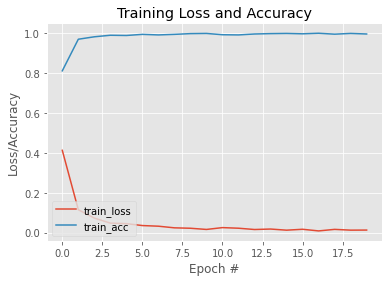

In [10]:
epochs_quantity = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs_quantity), training_history.history["loss"],     label="train_loss")
plt.plot(np.arange(0, epochs_quantity), training_history.history["accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(train_result_curve_image_path)